In [1]:
!pip install -q bitsandbytes peft datasets
!pip install -q -U transformers accelerate

!pip install -q tqdm matplotlib pandas numpy scikit-learn

import torch, transformers, bitsandbytes, datasets, peft
import tqdm, matplotlib, pandas, numpy, sklearn

print("Environment:")
print(f"Torch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Datasets: {datasets.__version__}")
print(f"PEFT: {peft.__version__}")
print(f"BitsAndBytes: {bitsandbytes.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

!nvidia-smi | head -n 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.4 MB/s eta 0:00:00
Environment:
Torch: 2.8.0+cu126
Transformers: 4.57.1
Datasets: 4.0.0
PEFT: 0.17.1
BitsAndBytes: 0.48.1
GPU available: True
Sat Oct 25 20:16:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             

In [2]:
# Load dataset and tokenizer

from datasets import load_dataset
from transformers import AutoTokenizer

model_id = "gpt2-medium"

dataset = load_dataset("vblagoje/cc_news", split="train[:2%]")
dataset = dataset.train_test_split(test_size=0.1, seed=42)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

train_data = dataset["train"].map(tokenize_function, batched=True, remove_columns=["text"])
val_data   = dataset["test"].map(tokenize_function, batched=True, remove_columns=["text"])

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

plain_text/train-00001-of-00005.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

plain_text/train-00002-of-00005.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

plain_text/train-00003-of-00005.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

plain_text/train-00004-of-00005.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/708241 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/12748 [00:00<?, ? examples/s]

Map:   0%|          | 0/1417 [00:00<?, ? examples/s]

Train samples: 12748, Validation samples: 1417


In [3]:
# Dataloaders

from torch.utils.data import DataLoader

def collate_fn(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])
    labels = input_ids.clone()
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_data, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(next(iter(train_loader))["input_ids"].shape)


torch.Size([4, 256])


In [4]:
# Load model with 4-bit quantization (QLoRA)

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

# Configure QLoRA adapters
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn", "c_proj"],
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 4,325,376 || all params: 359,148,544 || trainable%: 1.2043


In [5]:
# Optimizer and scheduler

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

num_epochs = 2
train_steps_per_epoch = len(train_loader)
total_steps = train_steps_per_epoch * num_epochs

optimizer = AdamW(model.parameters(), lr=2e-4)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.05 * total_steps), # Number of initial steps for warmup
    num_training_steps=total_steps
)


In [6]:
# Training loop

from tqdm.auto import tqdm

model.train()
train_losses = []

for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    total_loss = 0

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

Epoch 1:   0%|          | 0/3187 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 1 average loss: 2.7232


Epoch 2:   0%|          | 0/3187 [00:00<?, ?it/s]

Epoch 2 average loss: 2.5412


In [7]:
# Validation loop

import math

model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()

val_loss /= len(val_loader)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Perplexity: {math.exp(val_loss):.2f}")


Evaluating:   0%|          | 0/355 [00:00<?, ?it/s]


Validation Loss: 2.3836
Validation Perplexity: 10.84


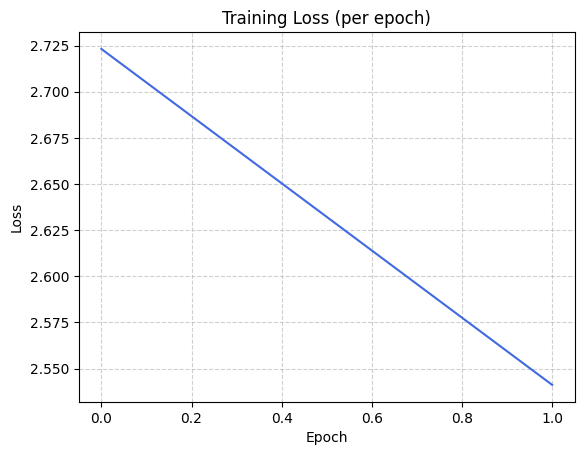

In [8]:
# Plot loss curve

import matplotlib.pyplot as plt

plt.plot(train_losses, color='royalblue')
plt.title("Training Loss (per epoch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [9]:
# Save fine-tuned model + tokenizer

save_path = "./sft_qlora_pytorch_gpt2_medium"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model saved to {save_path}")


Model saved to ./sft_qlora_pytorch_gpt2_medium


In [10]:
# Export core dependencies to requirements.txt

import importlib.metadata

# Define core project dependencies
core_packages = [
    "torch",
    "transformers",
    "datasets",
    "peft",
    "bitsandbytes",
    "accelerate",
    "tqdm",
    "matplotlib",
    "pandas",
    "numpy",
    "scikit-learn"
]

# Collect installed versions
with open("requirements.txt", "w") as f:
    for pkg in core_packages:
        try:
            version = importlib.metadata.version(pkg)
            f.write(f"{pkg}=={version}\n")
        except importlib.metadata.PackageNotFoundError:
            f.write(f"# {pkg} not installed\n")

print("requirements.txt created with core dependencies:")
!cat requirements.txt


requirements.txt created with core dependencies:
torch==2.8.0+cu126
transformers==4.57.1
datasets==4.0.0
peft==0.17.1
bitsandbytes==0.48.1
accelerate==1.11.0
tqdm==4.67.1
matplotlib==3.10.0
pandas==2.2.2
numpy==2.0.2
scikit-learn==1.6.1
